In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    ElasticNet,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_pickle("all_tweets_v12.pkl")
df = df[df.tweet_type == "standard"]
df.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,False
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0,False
3,1449804331142811655,[],1617597543000440844,2023-01-23 18

# Preprocessing

## Column Types

In [3]:
irrelevant_columns = [
    "author_id",
    "conversation_id",
    "created_at",
    "edit_history_tweet_ids",
    "id",
    "in_reply_to_user_id",
    "referenced_tweets",
    "reply_settings",
    # "text",  # incorporated with sentiment analysis, topic modelling
    "quote_count",
    "impression_count",
    "media_keys",  # Incorporated via n_media_keys
    "hashtags",
    "has_hashtags",
    "has_mentions",
    "urls",
    "mentions",
    "cashtags",
    "is_retweet",
    "ratio_like",
    "ratio_retweet",
    "hashtags_flattened",
    "trend_topics",
    "has_media",  # incorporated with n_media
    "is_reply",
    "tweet_type",
    "created_at_day_of_week",  # incorporated by cyclic features
    "created_at_month_of_year",  # incorporated by cyclic features
    "created_at_time_of_day_in_seconds",  # Incorporated by cyclic features
    "media_media_key_1",  # Incorporated via n_media_keys
    "media_media_key_2",  # Incorporated via n_media_keys
    "media_media_key_3",  # Incorporated via n_media_keys
    "media_media_key_4",  # Incorporated via n_media_keys
    "media_height_1",  # incorporated by resolution feature
    "media_height_2",  # incorporated by resolution feature
    "media_height_3",  # incorporated by resolution feature
    "media_height_4",  # incorporated by resolution feature
    "media_width_1",  # incorporated by resolution feature
    "media_width_2",  # incorporated by resolution feature
    "media_width_3",  # incorporated by resolution feature
    "media_width_4",  # incorporated by resolution feature
    "media_public_metrics_1",
    "media_public_metrics_2",
    "media_public_metrics_3",
    "media_public_metrics_4",
    "age_of_account_in_days_author",  # incorporated by "age_of_account_in_days_author_when_tweeted"
    "translated_tweet",
]

additional_irrelevant_columns = [
    "author",  # incorporating it as a categorical variable doesn't add any value
    # Bot score features
    "english",
    "universal",
    "eng_astroturf",
    "eng_fake_follower",
    "eng_financial",
    "eng_other",
    "eng_overall",
    "eng_self_declared",
    "eng_spammer",
    "uni_astroturf",
    "uni_fake_follower",
    "uni_financial",
    "uni_other",
    "uni_overall",
    "uni_self_declared",
    "uni_spammer",
]

# These columns are not available at prediction time
descriptive_columns = [
    "context_annotations",
    "possibly_sensitive",
    "withheld",
    "annotations",
    "media_url_1",
    "media_url_2",
    "media_url_3",
    "media_url_4",
    "media_preview_image_url_1",
    "media_preview_image_url_2",
    "media_preview_image_url_3",
    "media_preview_image_url_4",
    "media_alt_text_1",
    "media_alt_text_2",
    "media_alt_text_3",
    "media_alt_text_4",
    "created_at_year",
]

is_exist_columns = [
    "geo",
    "poll_ids",
]


categorical_columns = [
    "lang",
    "gender_of_author",
    "profession_of_author",
    "majority_lang",
    "media_type_1",
    "media_type_2",
    "media_type_3",
    "media_type_4",
    "sttm_topic",
]

binary_columns = [
    "verified_author",
    "political_context_annotation",
    "posted_during_an_important_event",
]

target_columns = [
    "retweet_count",
    "like_count",
    "reply_count",
]

numerical_columns = [
    "n_trend_topics",
    "text_length",
    "followers_count_author",
    "following_count_author",
    "tweet_count_author",
    "age_of_account_in_days_author_when_tweeted",
    "sentiment",
    "reply_to_tweet_ratio",
    "retweet_to_tweet_ratio",
    "average_tweets_of_author_per_day",
    "media_duration_ms_1",
    "media_duration_ms_2",
    "media_duration_ms_3",
    "media_duration_ms_4",
    "created_at_time_of_day_in_seconds_sin",
    "created_at_time_of_day_in_seconds_cos",
    "n_media_keys",
    "n_hashtags",
    "n_urls",
    "n_mentions",
    "media_resolution_1",
    "media_resolution_2",
    "media_resolution_3",
    "media_resolution_4",
    # emotions
    "positive",
    "fear",
    "trust",
    "sadness",
    "anticip",
    "surprise",
    "disgust",
    "anger",
    "joy",
    "anticipation",
    "negative",
]

In [4]:
all_columns = (
    irrelevant_columns
    + additional_irrelevant_columns
    + descriptive_columns
    + is_exist_columns
    + categorical_columns
    + binary_columns
    + target_columns
    + numerical_columns
)
for column_name in all_columns:
    assert all_columns.count(column_name) == 1
# assert set(all_columns) == set(df.columns), print(
#     set(all_columns).difference(set(df.columns)),
#     set(df.columns).difference(set(all_columns)),
# )

## Preprocessing columns

In [5]:
preprocessed_df = df.copy()
preprocessed_df.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,False
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0,False
3,1449804331142811655,[],1617597543000440844,2023-01-23 18

In [6]:
preprocessed_df[is_exist_columns] = preprocessed_df[is_exist_columns].isna()
authors = preprocessed_df.author.copy()
preprocessed_df = pd.get_dummies(preprocessed_df, columns=categorical_columns)
preprocessed_df["author"] = authors
# Impute columns with 0
media_columns_to_input = [
    f"{prefix}_{i}"
    for i in range(1, 5)
    for prefix in ["media_resolution", "media_duration_ms"]
]
for column in [
    "sentiment",
    "reply_to_tweet_ratio",
    "n_media_keys",
    "positive",
    "fear",
    "trust",
    "sadness",
    "anticip",
    "surprise",
    "disgust",
    "anger",
    "joy",
    "anticipation",
    "negative",
] + media_columns_to_input:
    preprocessed_df[column].fillna(0, inplace=True)

In [7]:
train_df, validation_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for author in preprocessed_df.author.unique():
    author_df = preprocessed_df[preprocessed_df.author == author].copy()
    author_df.sort_values(by="created_at", inplace=True)
    n_train = int(author_df.shape[0] * 0.8)
    n_validation = int(author_df.shape[0] * 0.1)

    train_df = pd.concat([train_df, author_df.iloc[:n_train].copy()], ignore_index=True)
    validation_df = pd.concat(
        [validation_df, author_df.iloc[n_train : (n_train + n_validation)].copy()],
        ignore_index=True,
    )
    test_df = pd.concat(
        [test_df, author_df.iloc[(n_train + n_validation) :].copy()], ignore_index=True
    )

train_validation_df = pd.concat([train_df, validation_df], ignore_index=True)

In [8]:
train_df.shape, validation_df.shape, train_validation_df.shape, test_df.shape

((72800, 255), (9028, 255), (81828, 255), (9274, 255))

In [9]:
# date_threshold = datetime(2023, 1, 1)

# train_df, test_df = (
#     preprocessed_df[preprocessed_df.created_at < date_threshold],
#     preprocessed_df[preprocessed_df.created_at >= date_threshold],
# )
# train_df.shape, test_df.shape, train_df.shape[0] + test_df.shape[0] == df.shape[0]

In [10]:
for dataset in [train_df, validation_df, train_validation_df, test_df]:
    dataset.drop(columns=irrelevant_columns, inplace=True)
    dataset.drop(columns=descriptive_columns, inplace=True)
    dataset.drop(columns=additional_irrelevant_columns, inplace=True)

In [11]:
# Columns with missing values. This is a simple test and it shouldn't print anything
for dataset in [train_df, validation_df, train_validation_df, test_df]:
    for i in dataset[dataset.isna().any(axis=1)].isna().any().items():
        if i[1]:
            print(i[0])

In [12]:
train_df.head()

,text,geo,retweet_count,like_count,reply_count,poll_ids,n_trend_topics,text_length,verified_author,followers_count_author,following_count_author,tweet_count_author,sentiment,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_duration_ms_1,media_duration_ms_2,media_duration_ms_3,media_duration_ms_4,political_context_annotation,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event,lang_ar,lang_art,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_lt,lang_lv,lang_nl,lang_no,lang_pl,lang_pt,lang_qam,lang_qht,lang_qme,lang_qst,lang_ro,lang_ru,lang_sl,lang_sv,lang_tl,lang_tr,lang_und,lang_vi,lang_zxx,gender_of_author_F,gender_of_author_M,gender_of_author_ORG,gender_of_author_UNKNOWN,profession_of_author_ACADEMICIAN,profession_of_author_ARTIST,profession_of_author_BASKETBALL PLAYER,profession_of_author_DOCTOR,profession_of_author_JOURNALIST,profession_of_author_LAWYER,profession_of_author_NOT AVAILABLE,profession_of_author_POLITICIAN,profession_of_author_TEACHER,profession_of_author_UNKNOWN,profession_of_author_WRITER,majority_lang_en,majority_lang_tr,media_type_1_animated_gif,media_type_1_photo,media_type_1_video,media_type_2_photo,media_type_2_video,media_type_3_photo,media_type_3_video,media_type_4_photo,media_type_4_video,sttm_topic_Uyghurs in China,sttm_topic_activism for nature,sttm_topic_ar,sttm_topic_art,sttm_topic_ca,sttm_topic_ckb,sttm_topic_cs,sttm_topic_cy,sttm_topic_da,sttm_topic_de,"sttm_topic_death, torture, suicide",sttm_topic_decree-law,sttm_topic_democracy,sttm_topic_dismissal of governmental workers,sttm_topic_el,sttm_topic_en,sttm_topic_es,sttm_topic_et,sttm_topic_eu,sttm_topic_expressing wishes,sttm_topic_fa,sttm_topic_fi,sttm_topic_fr,sttm_topic_freedom of speech,sttm_topic_hi,sttm_topic_ht,sttm_topic_hu,sttm_topic_hy,sttm_topic_in,"sttm_topic_inflation, financial instability",sttm_topic_injustice against children,sttm_topic_internatial relations,"sttm_topic_invitation, agenda declaration",sttm_topic_irrelevant tweets,sttm_topic_is,sttm_topic_it,sttm_topic_iw,sttm_topic_lost people,sttm_topic_lt,sttm_topic_lv,sttm_topic_nl,sttm_topic_no,sttm_topic_pl,sttm_topic_politics,sttm_topic_pt,sttm_topic_qam,sttm_topic_qht,sttm_topic_qme,sttm_topic_qst,sttm_topic_ro,sttm_topic_ru,sttm_topic_search for justice,sttm_topic_sl,sttm_topic_supreme court,sttm_topic_sv,sttm_topic_tl,sttm_topic_too_short_tweet,sttm_topic_und,sttm_topic_vi,"sttm_topic_vulnerable, sick people",sttm_topic_woman rights,sttm_topic_zxx
0,#BahadırlarYaşasın zulüm ve hukuksuzluklar ölsün,True,21,52,4,True,1,48,False,1107.0,174.0,2962.0,0.981266,0.013817,0.435233,1.231915,0.0,0.0,0.0,0.0,False,0.500000,-0.866025,0.0,1,0,0,0.0,0.0,0.0,0.0,0.200000,0.200000,0.0,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.000000,92.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hukuk ve adalet herkes için gereklidir\n\n#Bah...,True,31,53,4,True,1,58,False,1107.0,174.0,2962.0,0.992877,0.013817,0.435233,1.231915,0.0,0.0,0.0,0.0,False,-0.737277,-0.675590,0.0,1,0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,92.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# TDFIDF Vectorizer

In [13]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from TurkishStemmer import TurkishStemmer
from unidecode import unidecode


def get_stopwords(lang):
    stopwords = nltk.corpus.stopwords.words(lang)
    return [unidecode(i) for i in stopwords]


def preprocess_tweet_text(row):
    if row.lang_en:
        stopwords = stopwords_by_lang["en"]
        stemmer = stemmer_by_lang["en"]

    elif row.lang_fr:
        stopwords = stopwords_by_lang["fr"]
        stemmer = stemmer_by_lang["fr"]

    elif row.lang_tr:
        stopwords = stopwords_by_lang["tr"]
        stemmer = stemmer_by_lang["tr"]

    else:
        return row.text
    return " ".join([stemmer.stem(w) for w in row.text.split() if w not in stopwords])


stopwords_by_lang = {
    "tr": get_stopwords("turkish"),
    "fr": get_stopwords("french"),
    "en": get_stopwords("english"),
}
stemmer_by_lang = {
    "tr": TurkishStemmer(),
    "fr": nltk.stem.SnowballStemmer("french"),
    "en": nltk.stem.SnowballStemmer("english"),
}


# train_df["text_preprocessed"] = train_df.apply(preprocess_tweet_text, axis=1)
# validation_df["text_preprocessed"] = validation_df.apply(preprocess_tweet_text, axis=1)
# train_validation_df["text_preprocessed"] = train_validation_df.apply(
#     preprocess_tweet_text, axis=1
# )
# test_df["text_preprocessed"] = test_df.apply(preprocess_tweet_text, axis=1)

# all_tweet_texts_train = train_df.text_preprocessed.to_list()

In [14]:
def create_tfidf_features(dataset_df, vectorizer=None, max_features=1000):
    dataset_df["text_preprocessed"] = dataset_df.apply(preprocess_tweet_text, axis=1)
    all_tweet_texts = dataset_df.text_preprocessed.to_list()

    if vectorizer:
        sparse_tfidf_features = vectorizer.transform(all_tweet_texts)
    else:
        vectorizer = TfidfVectorizer(max_features=max_features)
        sparse_tfidf_features = vectorizer.fit_transform(all_tweet_texts)

    tfidf_df = pd.DataFrame.sparse.from_spmatrix(
        sparse_tfidf_features, columns=vectorizer.get_feature_names_out()
    )
    return pd.concat([dataset_df, tfidf_df], axis=1), vectorizer

In [15]:
# train_df, vectorizer = create_tfidf_features(train_df)
# validation_df, _ = create_tfidf_features(validation_df, vectorizer)
train_validation_df, vectorizer = create_tfidf_features(
    train_validation_df, max_features=5000
)
test_df, _ = create_tfidf_features(test_df, vectorizer)

# Modelling

In [16]:
last_irrelevant_columns = ["text", "text_preprocessed"]


def split_x_and_y(input_df):
    x = input_df[
        [
            c
            for c in input_df.columns
            if c not in target_columns + last_irrelevant_columns
        ]
    ].copy()
    y = input_df[[c for c in input_df.columns if c in target_columns]].copy()
    return x, y


x_train, y_train = split_x_and_y(train_df)
x_validation, y_validation = split_x_and_y(validation_df)
x_train_validation, y_train_validation = split_x_and_y(train_validation_df)
x_test, y_test = split_x_and_y(test_df)

print(
    x_train.shape,
    x_validation.shape,
    x_train_validation.shape,
    x_test.shape,
    y_train.shape,
    y_validation.shape,
    y_train_validation.shape,
    y_test.shape,
)

(72800, 171) (9028, 171) (81828, 5171) (9274, 5171) (72800, 3) (9028, 3) (81828, 3) (9274, 3)


In [17]:
for y in [y_train, y_validation, y_train_validation, y_test]:
    y["log_like_count"] = y.like_count.apply(lambda x: np.log(max(1, x)))
    if y.equals(y_train):
        print("Calculating lambda value for box-cox...")
        y["box_cox_like_count"], lambda_value = stats.boxcox(
            y.like_count.apply(lambda x: max(1, x))
        )
    else:
        y["box_cox_like_count"] = stats.boxcox(
            y.like_count.apply(lambda x: max(1, x)), lambda_value
        )
    y["square_root_like_count"] = y.like_count.apply(np.sqrt)

Calculating lambda value for box-cox...


In [18]:
def calculate_metrics(y_true, y_predicted):
    mae = metrics.mean_absolute_error(y_true, y_predicted)
    mse = metrics.mean_squared_error(y_true, y_predicted)
    r2 = metrics.r2_score(y_true, y_predicted)
    return mae, mse, r2

In [19]:
def back_transform_predictions(y_predicted, target_column):
    if target_column == "log_like_count":
        y_predicted = np.exp(y_predicted)
    elif target_column == "box_cox_like_count":
        y_predicted = (y_predicted * lambda_value + 1) ** (1 / lambda_value)
    elif target_column == "square_root_like_count":
        y_predicted = y_predicted**2
    return y_predicted


def evaluate(model, model_name, x, y_true, dataset_name, target_column):
    print("Predicting with the trained model")

    y_predicted = model.predict(x)
    y_predicted = back_transform_predictions(y_predicted, target_column)
    try:
        mae, mse, r2 = calculate_metrics(y_true, y_predicted)
    except ValueError:
        print("Error happened due to nan values.")
        return np.inf, np.inf, 0
    print(f"The {model_name} model performance for {dataset_name} set")
    print("--------------------------------------")
    print(f"MAE is {mae}")
    print(f"MSE is {mse}")
    print(f"R2 score is {r2}\n\n")
    return mae, mse, r2


def fine_tune_model(param_grid, model_class, model_name):
    model = model_class()
    best_r2 = 0
    best_params = None
    best_model = None
    for params in param_grid:
        target_column = params["target_column"]
        print(f"\n\nTraining {model_name} with params: {params}...\n\n")
        model.set_params(**{k: v for k, v in params.items() if k != "target_column"})
        model.fit(x_train, y_train[target_column])

        mae, mse, r2 = evaluate(
            model,
            model_name,
            x_validation,
            y_validation.like_count,
            "validation",
            target_column,
        )
        if r2 > best_r2:
            best_r2 = r2
            best_params = params
            best_model = model
    print(f"Found best params: {best_params}")
    return best_params, best_r2, best_model


def train_best_model(model_class, model_name, param_grid):
    best_params, best_r2, best_model = fine_tune_model(
        param_grid, model_class, model_name
    )
    # best_params = {
    #     "n_estimators": 1000,
    #     "n_jobs": -1,
    #     "random_state": 0,
    #     "target_column": "square_root_like_count",
    # }

    target_column = best_params["target_column"]
    evaluate(
        model,
        model_name,
        x_train_validation,
        y_train_validation.like_count,
        "train_and_validation",
        target_column,
    )
    evaluate(model, model_name, x_test, y_test.like_count, "test", target_column)
    return best_model, best_params["target_column"]

In [20]:
RANDOM_STATE = 0
random_forest_param_grid = ParameterGrid(
    {
        "n_estimators": [50, 200, 1000],
        "random_state": [RANDOM_STATE],
        "n_jobs": [-1],
        "target_column": [
            "square_root_like_count",
            "box_cox_like_count",
            "like_count",
            "log_like_count",
        ],
    }
)
# rf_model, target_column = train_best_model(
#     RandomForestRegressor, "RandomForestRegressor", random_forest_param_grid
# )

elastic_net_param_grid = ParameterGrid(
    {
        "random_state": [RANDOM_STATE],
        "l1_ratio": [0.3, 0.5, 0.7],
        "max_iter": [1000, 2000],
        "copy_X": [True],
        "selection": ["cyclic", "random"],
        "target_column": [
            "square_root_like_count",
            # "box_cox_like_count",
            # "like_count",
            # "log_like_count",
        ],
    }
)
# elastic_net_model, target_column = train_best_model(ElasticNet, "ElasticNet", elastic_net_param_grid)

linear_regression_param_grid = ParameterGrid(
    {
        "copy_X": [True],
        "n_jobs": [-1],
        "target_column": [
            "square_root_like_count",
            # "box_cox_like_count",
            # "like_count",
            # "log_like_count",
        ],
    }
)
# linear_regression_model, target_column = train_best_model(
#     LinearRegression, "LinearRegression", linear_regression_param_grid
# )

xgboost_param_grid = ParameterGrid(
    {
        "n_estimators": [100],
        "max_depth": [20, 30, 40],
        "eta": [0.3, 0.5],
        "subsample": [0.7],
        "colsample_bytree": [0.9],
        "n_jobs": [-1],
        "random_state": [RANDOM_STATE],
        "target_column": [
            "square_root_like_count",
            # "box_cox_like_count",
            # "like_count",
            "log_like_count",
        ],
    }
)
xgboost_best_params = {
    "colsample_bytree": 0.9,
    "eta": 0.3,
    "max_depth": 20,
    "n_estimators": 100,
    "n_jobs": -1,
    "subsample": 0.7,
    "target_column": "square_root_like_count",
}
# xgboost_model, target_column = train_best_model(
#     xgboost.XGBRFRegressor, "XGBRFRegressor", xgboost_param_grid
# )

In [22]:
# model = xgboost_model
model_name = "XGBRFRegressor"

model = xgboost.XGBRFRegressor()
target_column = xgboost_best_params["target_column"]
print(f"\n\nTraining with params: {xgboost_best_params}...\n\n")
params = {k: v for k, v in xgboost_best_params.items() if k != "target_column"}
params.update({"random_state": 0})
model.set_params(**params)
model.fit(x_train_validation, y_train_validation[target_column])



Training with params: {'colsample_bytree': 0.9, 'eta': 0.3, 'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'subsample': 0.7, 'target_column': 'square_root_like_count'}...




XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.9,
               early_stopping_rounds=None, enable_categorical=False, eta=0.3,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=20, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=-1, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=0, ...)

In [24]:
model_name = "XGBRFRegressor"

evaluate(
    model,
    model_name,
    x_train_validation,
    y_train_validation.like_count,
    "train_validation",
    target_column,
)
evaluate(model, model_name, x_test, y_test.like_count, "test", target_column)

Predicting with the trained model
The XGBRFRegressor model performance for train_validation set
--------------------------------------
MAE is 84.20220918181023
MSE is 194617.95437353043
R2 score is 0.8908422916200028


Predicting with the trained model
The XGBRFRegressor model performance for test set
--------------------------------------
MAE is 140.42767617907592
MSE is 569319.8552719578
R2 score is 0.6555626945278328




(140.42767617907592, 569319.8552719578, 0.6555626945278328)

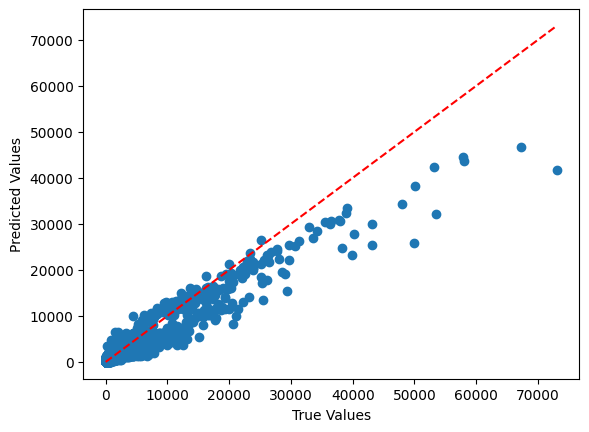

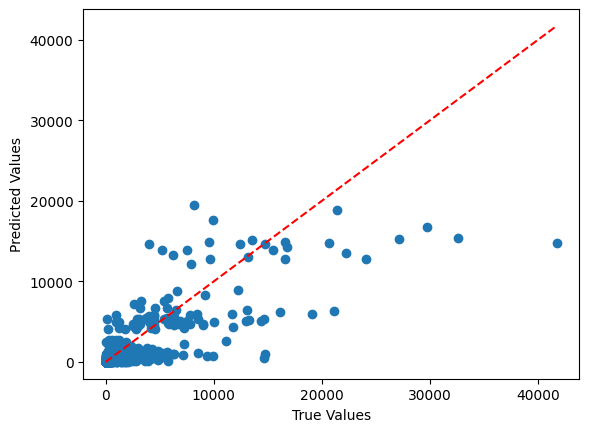

In [25]:
y_train_validation_predicted = model.predict(x_train_validation)
y_test_predicted = model.predict(x_test)

y_train_validation_predicted = back_transform_predictions(
    y_train_validation_predicted, "square_root_like_count"
)
y_test_predicted = back_transform_predictions(
    y_test_predicted, "square_root_like_count"
)


# plot the predicted values against the true values
def plot_predicted_vs_true(y_true, y_predicted):
    plt.scatter(y_true.like_count, y_predicted)
    plt.plot(
        [min(y_true.like_count), max(y_true.like_count)],
        [min(y_true.like_count), max(y_true.like_count)],
        "--",
        color="red",
    )
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()


plot_predicted_vs_true(y_train_validation, y_train_validation_predicted)
plot_predicted_vs_true(y_test, y_test_predicted)

In [26]:
# pd.DataFrame(y_test_predicted)
# y_test.like_count

In [27]:
y_test_like_counts = y_test.like_count.to_frame()
y_test_like_counts["predicted"] = y_test_predicted
y_test_like_counts.head()

,like_count,predicted
0,7,3.647883
1,3,3.493146
2,1,3.705305
3,6,3.538517
4,11,3.149312


In [28]:
def return_tweet_like_range(like_count):
    if like_count < 20:
        return "<20"
    elif like_count < 100:
        return "<100"
    elif like_count < 500:
        return "<500"
    elif like_count < 1000:
        return "<1000"
    else:
        return ">1000"


y_test_like_counts["range"] = y_test_like_counts.like_count.apply(
    return_tweet_like_range
)
y_test_like_counts.head()

,like_count,predicted,range
0,7,3.647883,<20
1,3,3.493146,<20
2,1,3.705305,<20
3,6,3.538517,<20
4,11,3.149312,<20


In [29]:
import pandas as pd
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

# group the data by the values in the "group" column
grouped = y_test_like_counts.groupby("range")
pd.options.display.float_format = "{:.0f}".format

# calculate MSE for each group
mse_by_group = grouped.apply(
    lambda x: mean_squared_error(x["like_count"], x["predicted"])
)
mae_by_group = grouped.apply(
    lambda x: mean_absolute_error(x["like_count"], x["predicted"])
)

mape_by_group = grouped.apply(
    lambda x: mean_absolute_percentage_error(x["like_count"], x["predicted"])
)

print(mape_by_group, mse_by_group, mae_by_group)

range
<100                   1
<1000                  1
<20     2330607314641512
<500                   1
>1000                  1
dtype: float64 range
<100        6487
<1000     412437
<20          405
<500      117670
>1000   12593741
dtype: float64 range
<100      36
<1000    429
<20        8
<500     182
>1000   2121
dtype: float64


In [ ]:
mean_absolute_percentage_error(
    y_test_like_counts.like_count, y_test_like_counts.predicted
)

In [ ]:
type(mse_by_group)
pd.options.display.float_format = "{:.0f}".format

# TODO

1. Outlier Detection
2. Done - Different model architectures - Try to overfit on training set
    - RANSAC
    - SVR
    - XGBoost
3. Shapley values for black-box models
4. Done - Better train test split
5. Done -  Calculate age of the account according to tweet date
6. Done - Include important events as a feature
7. Done - Better model evaluation
8. Not needed - Box cox transformation based on train_validation
9. Create a dataframe for fine tuning
10. Literature Review
    - TFIDF
    - Word Embeddings

In [ ]:
import numpy as np

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

In [ ]:
import pandas as pd

forest_importances = pd.Series(importances, index=x_train.columns)

filter_threshold = 0.001
filtered_importances = forest_importances[forest_importances > filter_threshold]
filtered_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(20, 20))
# filtered_importances.drop(
#     index=[ind for ind in filtered_importances.index if ind.startswith("author")]
# ).plot.bar(ax=ax)
filtered_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig("feature_importances.png")  # save the figure to file

In [ ]:
# # def fit_and_evaluate(model_name, model_params, target_column):
# #     model_class, params = model_params
# #     model = model_class(**params)
# #     print("Training the model")
# #     # model.fit(x_train, y_train[target_column])
# #     model.fit(x_train_validation, y_train_validation[target_column])

# #     evaluate(model, model_name, x_train, y_train[target_column], "training")
# #     evaluate(model, model_name, x_validation, y_validation[target_column], "validation")
# #     evaluate(
# #         model,
# #         model_name,
# #         x_train_validation,
# #         y_train_validation[target_column],
# #         "validation",
# #     )
# #     evaluate(model, model_name, x_test, y_test[target_column], "test")

# #     return model

# model_classes = {
#     # "decision_tree": (DecisionTreeRegressor, {"random_state": 0}),
#     # "linear_regression": (LinearRegression, {}),
#     # "random_forest": (
#     #     RandomForestRegressor,
#     #     {"n_estimators": 50, "random_state": 0, "n_jobs": -1, "verbose": 1},
#     # ),
#     "random_forest": (
#         RandomForestRegressor,
#         {"n_estimators": 1000, "random_state": 0, "n_jobs": -1},
#     ),
# }

# target_column = "box_cox_like_count"  #  "square_root_like_count", "box_cox_like_count", "like_count",  "log_like_count"
# models = {}
# for model_name, params in model_classes.items():
#     models[model_name] = fit_and_evaluate(model_name, params, target_column)

In [ ]:
models["linear_regression"].coef_

# feature_names = models["linear_regression"].get_feature_names_out()
#
coefs = pd.DataFrame(
    models["linear_regression"].coef_,
    columns=["Coefficients"],
    index=models["linear_regression"].feature_names_in_,
)

coefs.sort_values(by="Coefficients")